In [4]:
#From functions 2.0

# General arr lib
import numpy as np

# Compile py code
from numba import jit, njit
from numba import prange

# Multithreading
import dask.array as da
import dask as dk
from dask import delayed
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster
dk.config.set(scheduler='processes')

from dask_image.ndfilters import generic_filter as d_gf

from collections import deque

from skimage.filters import gabor
from skimage.restoration import  denoise_bilateral
from skimage.transform import resize  # For downsampling

from scipy.ndimage import gaussian_filter, generic_filter as gf
from scipy.ndimage import median_filter, uniform_filter 
from scipy.ndimage import generic_filter

import datetime

import numpy as np
from numpy import random, nanmax, argmax, unravel_index
from scipy.spatial.distance import pdist, squareform
import scipy.stats.mstats as ms
from scipy.stats import skew
import scipy.ndimage.morphology as morph
from scipy import ndimage
from PIL import Image
import scipy
import matplotlib.pyplot as plt
import re
import os
import pandas as pd
import random
import math
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral, denoise_wavelet, estimate_sigma)
from skimage import data, img_as_float
from skimage.filters import gabor
from skimage.util import random_noise
from collections import deque
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load
from sklearn.metrics import cohen_kappa_score, accuracy_score, recall_score, confusion_matrix, precision_score
from numba import jit
from numba import prange
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable

from Functions import general_functions
from Functions.general_functions import create_circular_mask

Zone 12: Loaded HPMF data with shape (5000, 5000)


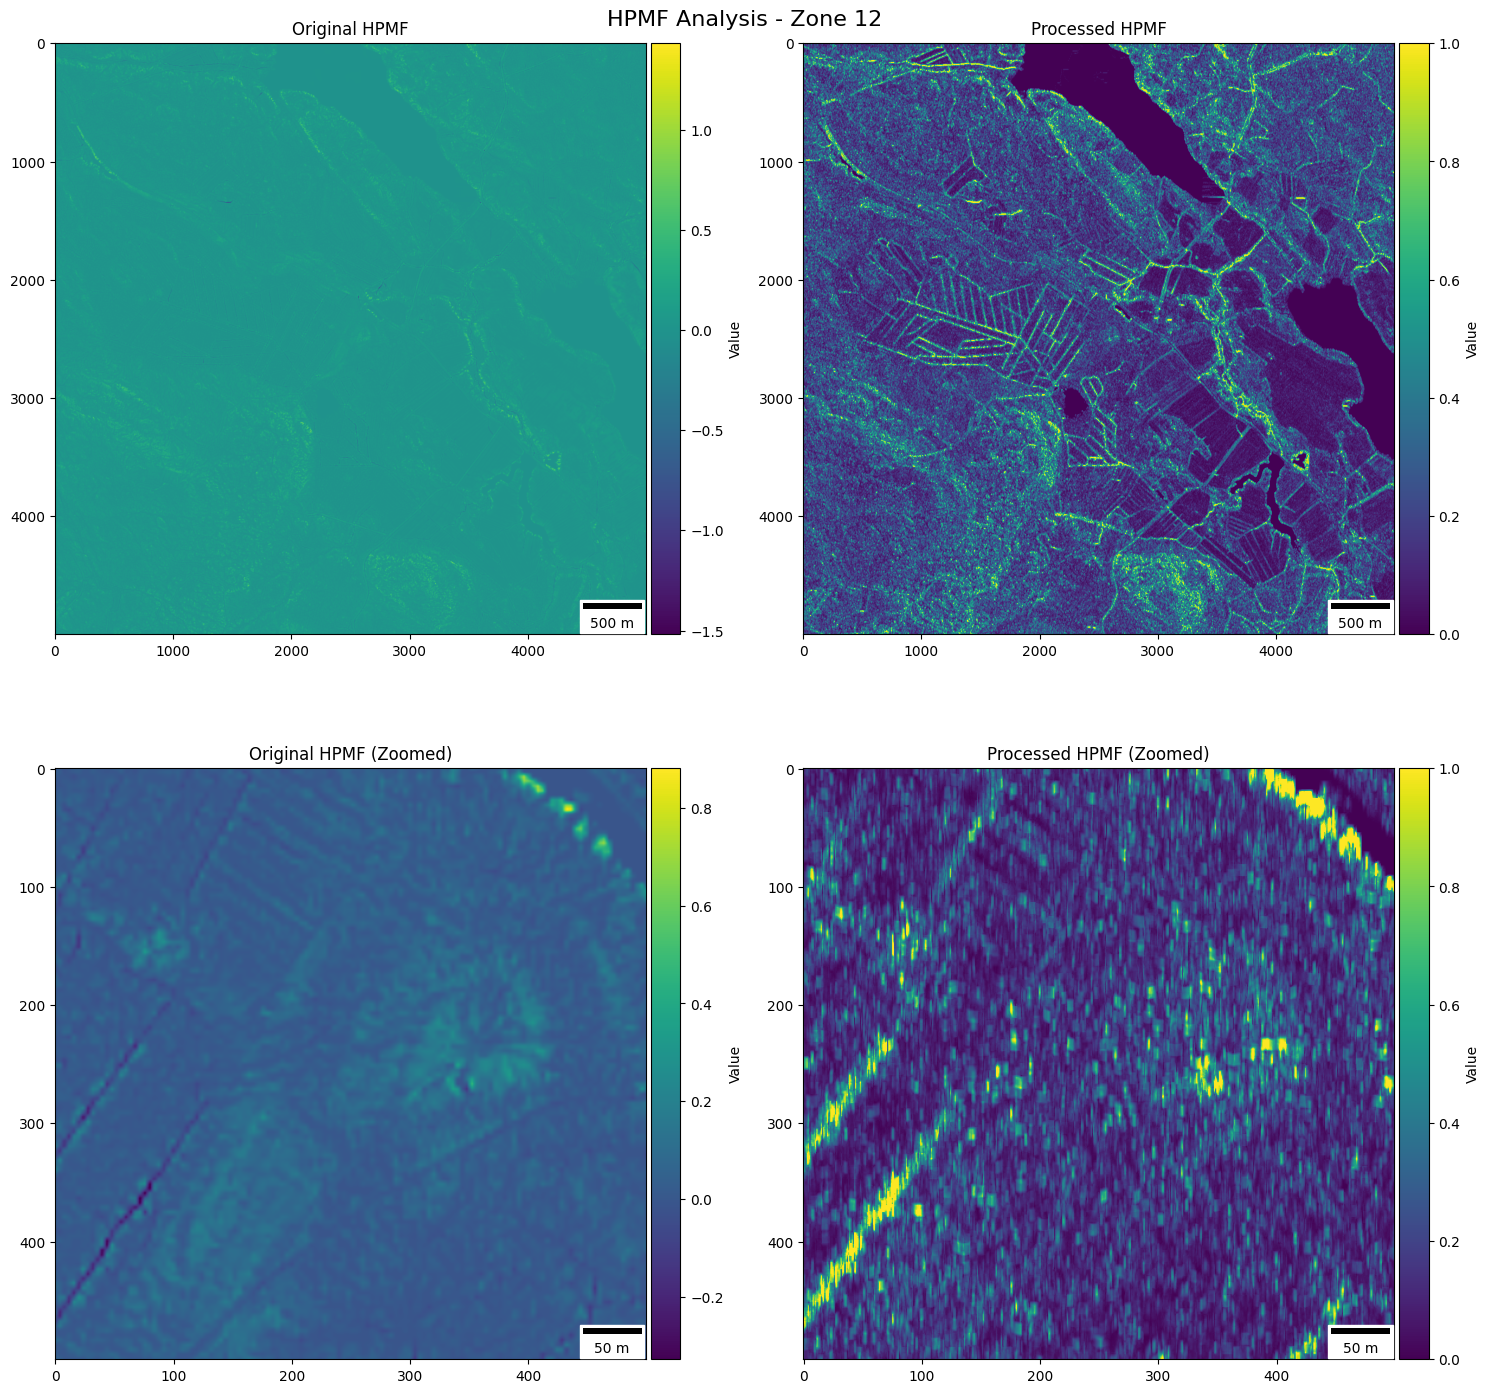

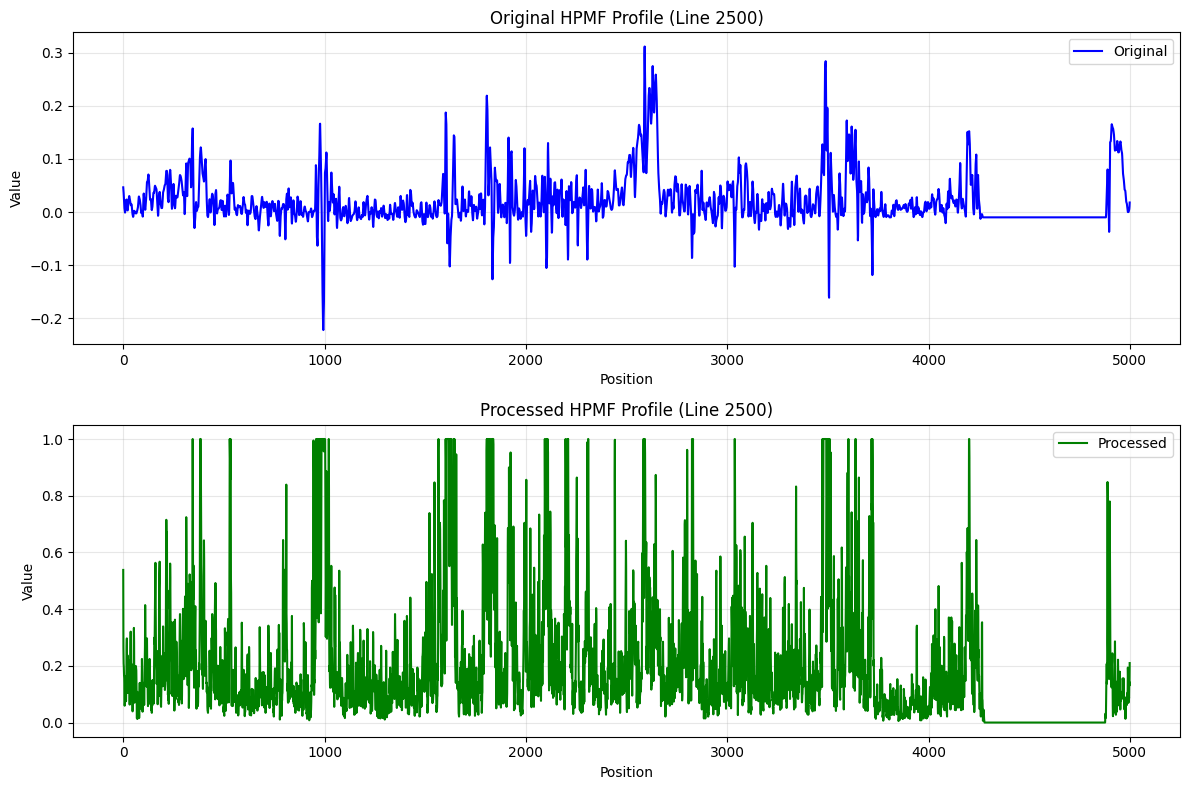

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib_scalebar.scalebar import ScaleBar

def compute_mean_min_norm_hpmf(lines, shift_range=5):
    """Compute pixel-wise mean of min norms for better preservation."""
    n_lines = len(lines)
    if n_lines < 2:
        return np.zeros(lines.shape[1])  # Return zero array if not enough rows
    
    min_norms = np.full((n_lines - 1, lines.shape[1]), np.inf)  # Shape correction
    
    for i in range(1, n_lines):
        line1 = lines[i]
        line2 = lines[i - 1]
        
        for shift in range(-shift_range, shift_range + 1):
            shifted_line2 = np.roll(line2, shift)
            norm = np.abs(line1 - shifted_line2)  # Element-wise absolute difference
            min_norms[i - 1] = np.minimum(min_norms[i - 1], norm)
    
    return np.nanmean(min_norms, axis=0)  # Compute column-wise mean

def process_and_visualize_hpmf(zone_number, features_path="../../01_Data/01_Raw/features/features", 
                             save_path=None, dpi=300):
    """Load, process, and visualize HPMF data."""
    
    # Load HPMF data
    try:
        hpmf = np.load(f"{features_path}/HPMF_{zone_number}.npy").astype(np.float32)  # Ensure float
        print(f"Zone {zone_number}: Loaded HPMF data with shape {hpmf.shape}")
    except FileNotFoundError:
        raise FileNotFoundError(f"HPMF file not found for zone {zone_number}")
    
    # Handle missing values
    hpmf = np.where(hpmf == -99999, np.nan, hpmf)
    
    if hpmf.ndim != 2:
        raise ValueError("HPMF data must be a 2D array")
    
    # Initialize the processed array
    hpmf_processed = np.zeros_like(hpmf, dtype=np.float32)  # Ensure float

    # Process each row individually
    for i in range(hpmf.shape[0]):
        row_result = compute_mean_min_norm_hpmf(hpmf[max(0, i-5):min(hpmf.shape[0], i+6)])
        hpmf_processed[i, :] = row_result  # Assign processed row
    
    # Normalize using percentiles to avoid extreme values
    v_min, v_max = np.nanpercentile(hpmf_processed, [2, 98])  # Robust normalization
    hpmf_processed = (hpmf_processed - v_min) / (v_max - v_min)
    hpmf_processed = np.clip(hpmf_processed, 0, 1)  # Clip to [0,1] range
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    fig.suptitle(f'HPMF Analysis - Zone {zone_number}', fontsize=16, y=0.95)
    
    def add_colorbar(im, ax, label):
        """Helper function to add colorbar"""
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        return plt.colorbar(im, cax=cax, label=label)
    
    # Plot original and processed images
    for ax, data, title in zip(axes.flat[:2], [hpmf, hpmf_processed], ['Original HPMF', 'Processed HPMF']):
        im = ax.imshow(data, cmap='viridis', aspect='equal')
        ax.set_title(title)
        add_colorbar(im, ax, 'Value')
        ax.add_artist(ScaleBar(1, location='lower right', units="m", length_fraction=0.15))

    # Zoomed-in section
    center_y, center_x = hpmf.shape[0]//2, hpmf.shape[1]//2
    zoom_size = 500  # Size of zoom window
    zoom_slice = np.s_[center_y-zoom_size//2:center_y+zoom_size//2,
                        center_x-zoom_size//2:center_x+zoom_size//2]
    
    for ax, data, title in zip(axes.flat[2:], [hpmf[zoom_slice], hpmf_processed[zoom_slice]], 
                               ['Original HPMF (Zoomed)', 'Processed HPMF (Zoomed)']):
        im = ax.imshow(data, cmap='viridis', aspect='equal')
        ax.set_title(title)
        add_colorbar(im, ax, 'Value')
        ax.add_artist(ScaleBar(1, location='lower right', units="m", length_fraction=0.15))

    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
        print(f"Saved visualization to {save_path}")
    
    plt.show()
    
    return {
        "zone_number": zone_number,
        "original_shape": hpmf.shape,
        "processed_shape": hpmf_processed.shape,
        "original_data": hpmf,
        "processed_data": hpmf_processed,
    }

def plot_line_profiles(hpmf_original, hpmf_processed, line_index=None):
    """Plot original and processed line profiles."""
    if line_index is None:
        line_index = hpmf_original.shape[0] // 2
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    ax1.plot(hpmf_original[line_index, :], label='Original', color='blue')
    ax1.set_title(f'Original HPMF Profile (Line {line_index})')
    ax1.set_xlabel('Position')
    ax1.set_ylabel('Value')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    ax2.plot(hpmf_processed[line_index, :], label='Processed', color='green')
    ax2.set_title(f'Processed HPMF Profile (Line {line_index})')
    ax2.set_xlabel('Position')
    ax2.set_ylabel('Value')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    zone_number = 12
    result = process_and_visualize_hpmf(zone_number)
    plot_line_profiles(result['original_data'], result['processed_data'])


Zone 12: Shape of original HPMF_f: (5000, 5000)


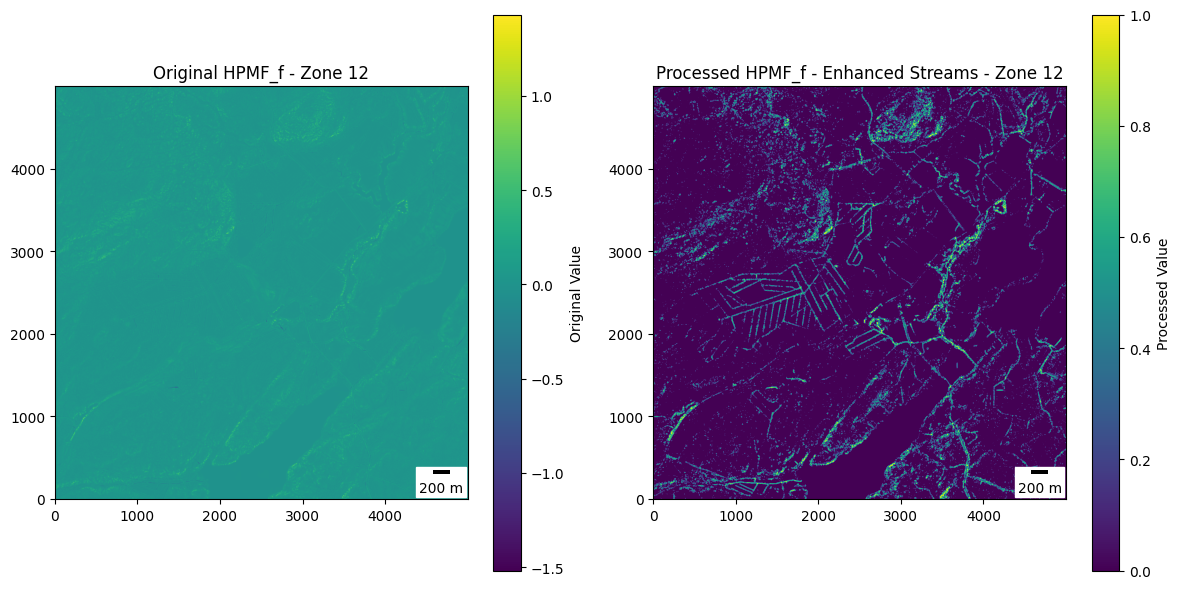

In [26]:
import numpy as np
import dask.array as da
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from scipy.ndimage import gaussian_filter, sobel

features_path = "../../01_Data/01_Raw/features/features"


def create_circular_mask(radius):
    """
    Create a circular mask with a given radius.
    """
    size = 2 * radius + 1
    y, x = np.ogrid[-radius:size - radius, -radius:size - radius]
    mask = x**2 + y**2 <= radius**2
    return mask


def hpmf_f(data, mask_radius=6):
    """
    Detects meandering forms using circular masks and Dask-compatible filters.

    Parameters:
    - data: Input 2D array (Dask array or NumPy array).
    - mask_radius: Radius of the circular mask.

    Returns:
    - result: Processed 2D array with enhanced meandering forms.
    """
    # Convert to Dask array for processing if it's not already a Dask array
    if not isinstance(data, da.Array):
        data_dask = da.from_array(data, chunks=(800, 800))
    else:
        data_dask = data

    # Normalize input data for processing
    data_norm = (data_dask - data_dask.min()) / (data_dask.max() - data_dask.min())

    # Create the circular mask
    circular_mask = create_circular_mask(mask_radius)

    # Apply filters to enhance meandering forms (nested filters combined)
    enhanced_data = data_norm  # Placeholder, no processing applied for now

    return enhanced_data


def enhance_streams(image, sigma=1):
    """
    Enhance stream-like structures by applying Gaussian smoothing and Sobel edge detection.
    
    Parameters:
    - image: 2D array (Dask or NumPy array).
    - sigma: Standard deviation for the Gaussian filter to smooth the image before enhancing edges.

    Returns:
    - Enhanced image highlighting stream-like structures.
    """
    # Apply Gaussian filter to smooth the image
    smoothed_image = gaussian_filter(image, sigma=sigma)

    # Apply Sobel filter to detect edges (stream-like features)
    sobel_x = sobel(smoothed_image, axis=0)
    sobel_y = sobel(smoothed_image, axis=1)
    
    # Combine Sobel results to get the magnitude of edges
    sobel_magnitude = np.hypot(sobel_x, sobel_y)

    # Optional: Threshold to highlight stronger edges (streams)
    threshold = np.percentile(sobel_magnitude, 95)  # Keep top 5% edges
    enhanced_streams = sobel_magnitude > threshold

    return enhanced_streams


def process_visualize_hpmf_f(zone_number, sigma=1):
    """
    Load, process, and visualize the HPMF data for a given zone.

    Parameters:
    - zone_number: The zone number to process.

    Returns:
    - A dictionary with zone information and data shapes.
    """
    # Load the hpmf data for the specified zone
    hpmf_f_path = f"{features_path}/HPMF_{zone_number}.npy"
    hpmf_f = np.load(hpmf_f_path)  # hpmf is now the NumPy array
    print(f"Zone {zone_number}: Shape of original HPMF_f: {hpmf_f.shape}")

    # Ensure no -99999 values (replace with NaN)
    hpmf_f[hpmf_f == -99999] = np.nan

    # Process the hpmf data
    if hpmf_f.ndim != 2:
        raise ValueError("HPMF data must be a 2D array.")

    # Apply stream enhancement to the image
    hpmf_f_processed = enhance_streams(hpmf_f, sigma=sigma)

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Original HPMF
    im1 = axes[0].imshow(hpmf_f, cmap="viridis", origin="lower")
    axes[0].set_title(f"Original HPMF_f - Zone {zone_number}")
    fig.colorbar(im1, ax=axes[0], label="Original Value")

    # Add scalebar to original image
    scalebar1 = ScaleBar(1, location='lower right', units="m", length_fraction=0.1)
    axes[0].add_artist(scalebar1)

    # Processed HPMF (Enhanced streams)
    im2 = axes[1].imshow(hpmf_f_processed, cmap="viridis", origin="lower")
    axes[1].set_title(f"Processed HPMF_f - Enhanced Streams - Zone {zone_number}")
    fig.colorbar(im2, ax=axes[1], label="Processed Value")

    # Add scalebar to processed image
    scalebar2 = ScaleBar(1, location='lower right', units="m", length_fraction=0.1)
    axes[1].add_artist(scalebar2)

    # Display
    plt.tight_layout()
    plt.show()

    # Return the processed data
    return {
        "zone_number": zone_number,
        "original_shape": hpmf_f.shape,
        "processed_shape": hpmf_f_processed.shape
    }

# Example: Process and visualize a single zone
zone_number = 12  # Change this as needed
result = process_visualize_hpmf_f(zone_number)
